# Modular coding - Lightning

## Writing the example using PyTorch Lightning

PyTorch Lightning is a deep learning framework that has helper classes and functions designed to make creating PyTorch models easier.

In [1]:
# Import needed modules
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lightning as L

## Data handling - LightningDataModule

Previously our data loading code looked like this:

```python
# Set up data sets and data loaders

data_dir = "../data"

batch_size = 32

train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
```

PyTorch Lightning utilizes a class called [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule) to combine data setup, data set specification and data loader creation. This makes it easier to keep the data loading in a modular form.

Rewriting the previous example with LightningDataModule looks like this:

In [2]:
class MNISTDataModule(L.LightningDataModule):

    def __init__(self, data_dir="../data", batch_size=32):
        # In init-function you can set arguments like data paths
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage):
        # setup-function is used to specify the datasets
        if stage == "fit":
            self.train_dataset = datasets.MNIST(
                self.data_dir, train=True, download=True, transform=ToTensor()
            )
        if stage == "test":
            self.test_dataset = datasets.MNIST(
                self.data_dir, train=False, transform=ToTensor()
            )

    def train_dataloader(self):
        # train_dataloader specifies how to set up a training dataloader
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        # test_dataloader specifies how to set up a test dataloader
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False)

## Model writing - LightningModule

Models in PyTorch Lightning are written as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), which extends PyTorch's nn.Module with extra functionality. New functions `training_step` and `test_step` specify how we want to calculate each batch during training and testing while `configure_optimizers` specifies how the optimizers are set up.

We can also include a `validation_step`-function to validate our training accuracy on some data that the model has not seen, but this is not included for simplicity. In actual training this should be present.

In [3]:
class SimpleMLP(L.LightningModule):
    def __init__(self, hidden_size=20):
        # Init is done similar to nn.Module
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )
        # We specify loss function in the module as well
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        # Forward is done similar to nn.Module
        return self.layers(x)

    def training_step(self, batch):
        # training_step-function specifies how data is fed into the model and how the loss is calculated
        data, target = batch
        outputs = self(data)

        # Calculate the loss
        loss = self.loss(outputs, target)

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == target).sum().item()

        batch_size = outputs.shape[0]

        # Log loss and number of correct predictions
        self.log("training_loss", loss, on_epoch=True, on_step=False)
        self.log(
            "training_accuracy", correct / batch_size, on_epoch=True, on_step=False
        )

        # training_step returns the loss
        return loss

    def test_step(self, batch):
        # test_step-function specifies how data is fed into the model and how the loss is calculated
        data, target = batch
        outputs = self(data)

        # Calculate the loss
        loss = self.loss(outputs, target)

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == target).sum().item()

        batch_size = outputs.shape[0]

        # Log loss and number of correct predictions
        self.log("test_loss", loss, on_epoch=True, on_step=False)
        self.log("test_accuracy", correct / batch_size, on_epoch=True, on_step=False)

        # training_step returns the loss
        return loss

    def configure_optimizers(self):
        # configure_optimizers-function specifies how the optimizer is created
        return torch.optim.AdamW(self.layers.parameters())

## Logging - CSVLogger

PyTorch supports [various loggers](https://lightning.ai/docs/pytorch/stable/api_references.html#loggers) that can record model's training process.

For this simple example let's use the [CSVLogger](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.csv_logs.html#module-lightning.pytorch.loggers.csv_logs).

In [4]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="mnist_example")

## Training - Trainer

PyTorch Lightning has a class called [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) that can train the model without the need to write a training loop. Given a model (that now also contains specifications for our loss and optimizer functions) and a data module (that now also contains our dataset specification and our dataloader specification), it will handle the training automatically on any accelerator that is present.

In [5]:
from lightning.pytorch.callbacks import TQDMProgressBar

In [6]:
model = SimpleMLP()
datamodule = MNISTDataModule()

trainer = L.Trainer(
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=100)],
    logger=logger,
)

/scratch/work/tuomiss1/conda_envs/ml-reproducibility/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/work/tuomiss1/conda_envs/ml-reproducibility ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA H200 MIG 2g.35gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-09918c9f-86b8-5626-9a0f-7d30ab8d1f8d]

  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | layers | Sequential       | 15.9 K | train
1 | loss   | CrossEntropyLoss | 0      | train
----------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/scratch/work/tuomiss1/conda_envs/ml-reproducibility/lib/python3.12/site-packages/lightning/pytorch/trainer/connec

Epoch 4: 100%|██████████| 1875/1875 [00:05<00:00, 336.45it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1875/1875 [00:05<00:00, 335.92it/s, v_num=3]


## Visualize training

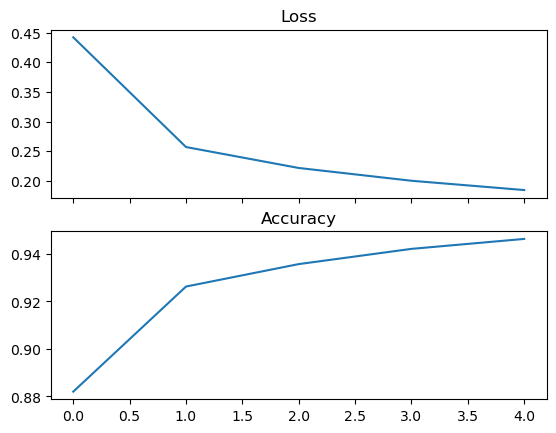

In [8]:
import os.path

metrics = pd.read_csv(os.path.join("logs", "mnist_example", "version_0", "metrics.csv"))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(metrics["epoch"], metrics["training_loss"])
ax1.set_title("Loss")
ax2.plot(metrics["epoch"], metrics["training_accuracy"])
ax2.set_title("Accuracy")

fig.show()

## Testing

Trainer can also run testing on the model:

In [9]:
trainer.test(model, datamodule=datamodule)

/scratch/work/tuomiss1/conda_envs/ml-reproducibility/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/work/tuomiss1/conda_envs/ml-reproducibility ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-09918c9f-86b8-5626-9a0f-7d30ab8d1f8d]
/scratch/work/tuomiss1/conda_envs/ml-reproducibility/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1875/1875 [00:03<00:00, 517.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9598833322525024
        test_loss           0.14220863580703735
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.14220863580703735, 'test_accuracy': 0.9598833322525024}]

## Example as a script

A version of this example written as a script is shown in `examples/example3`.